In [102]:
%pip install yfinance

In [103]:
pip install fredapi

In [104]:
# Funciones numéricas adicionales
import numpy as np
import statsmodels.api as sm
from datetime import datetime

# Lectura de datos y manejo de Data-sets
import pandas as pd

# Datos
import yfinance as yfin

# Gráficos
import matplotlib.pyplot as plt
import seaborn as sns

# Funciones para iterar sobre estructuras especificas
import itertools

# Funciones para optimizar
from scipy.optimize import minimize

In [105]:
from fredapi import Fred

In [106]:
# FRED_API_KEY
fred = Fred(api_key='a3d8a45391e92cc5c30c9c255819c138')

## Punto 1: Definir alcance y Datos

In [107]:
fechaInicio = "2015-01-01"
fechaFin = "2025-01-01"
# El analisis se realizara con una frecuencia diaria inicialmente

fechaInicio_dt = pd.to_datetime(fechaInicio)
fechaFin_dt = pd.to_datetime(fechaFin)

#empresas escogidas inicialmente
tickers = ['NKE', 'TPR', 'VFC', 'ADDYY', 'PVH']


###Análisis diario:

Hacer el análisis diario primero es valioso porque permite trabajar con la información más completa y detallada posible. Al observar los movimientos día a día, se capturan mejor los eventos relevantes del mercado, las fluctuaciones reales del precio y el impacto exacto de los dividendos. Esto produce estimaciones más precisas de volatilidad, retornos y riesgos, lo que sirve como base sólida para cualquier análisis posterior más agregado, como el mensual o anual.

###Compañias

Nike (NKE)
Compañía estadounidense líder mundial en ropa, calzado y equipamiento deportivo. Conocida por su innovación, alto reconocimiento de marca y fuerte presencia global en ventas directas y retail.

Tapestry (TPR)
Holding estadounidense dueño de marcas de lujo accesible como Coach, Kate Spade y Stuart Weitzman. Su negocio se centra en accesorios, bolsos y moda de precio premium.

VF Corporation (VFC)
Empresa estadounidense de ropa y calzado dueña de marcas como The North Face, Vans y Timberland. Tradicionalmente fuerte en outdoor y streetwear, pero en los últimos años enfrenta retos operativos.

Adidas AG – ADR (ADDYY)
Versión ADR de Adidas, compañía alemana de ropa y calzado deportivo. Es la segunda marca deportiva más grande del mundo, reconocida por sus productos de performance, moda urbana y colaboraciones globales.

PVH Corp (PVH)
Empresa estadounidense que posee marcas globales de moda como Calvin Klein y Tommy Hilfiger. Su enfoque está en ropa casual y formal, con una amplia presencia en retail internacional.

In [108]:
# Descargamos datos FRED
sofr = pd.DataFrame(fred.get_series('SOFR', fechaInicio_dt, fechaFin_dt))
sofr  = sofr .dropna()
sofr.index.names = ['Date']
sofr.columns = ["SOFR"]
sofr["SOFR"] = sofr["SOFR"]/100
sofr

,SOFR
Date,
2018-04-03,0.0183
2018-04-04,0.0174
2018-04-05,0.0175
2018-04-06,0.0175
2018-04-09,0.0175
...,...
2024-12-24,0.0440
2024-12-26,0.0453
2024-12-27,0.0446


In [109]:
SOFR = sofr.iloc[-1]['SOFR']
SOFR

np.float64(0.0449)

In [110]:
# Calculate the monthly average
monthly_sofr = sofr.resample('ME').mean()
display(monthly_sofr)

,SOFR
Date,
2018-04-30,0.017420
2018-05-31,0.017305
2018-06-30,0.018367
2018-07-31,0.019138
2018-08-31,0.019174
...,...
2024-08-31,0.053327
2024-09-30,0.051455
2024-10-31,0.048491


In [111]:
# Descargar precios diarios ajustados de Empresas
df = pd.DataFrame()

# Intervalos diarios
for symbol in tickers:
    df[symbol] = yfin.download(
        symbol,
        start=fechaInicio_dt,
        end=fechaFin_dt,
        interval="1d"
    )["Close"]

/tmp/ipython-input-2145234101.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df[symbol] = yfin.download(
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2145234101.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df[symbol] = yfin.download(
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2145234101.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df[symbol] = yfin.download(
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2145234101.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df[symbol] = yfin.download(
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2145234101.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df[symbol] = yfin.download(
[***

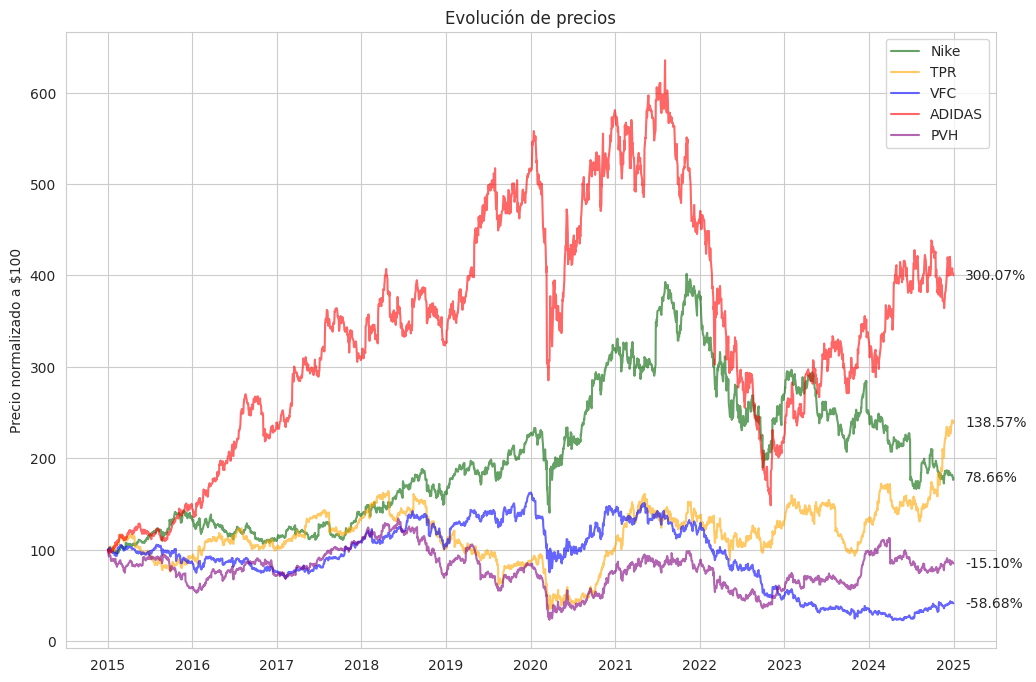

In [112]:
#Series Historicas

# Normalizar los precios al primer día disponible en el DataFrame
df_100 = df.div(df.iloc[0]).mul(100)
df_100

# Graficar
plt.figure(figsize=(12, 8))

# Calculate percentage change for each company
for company in tickers:
    # Find the closest available date in df_100 for fecha_inicio
    initial_date_in_df = df_100.index[df_100.index >= fechaInicio].min()
    initial_price = df_100[company].loc[initial_date_in_df]

    # Find the closest available date in df_100 for fecha_fin
    final_date_in_df = df_100.index[df_100.index <= fechaFin].max()
    final_price = df_100[company].loc[final_date_in_df]

    percentage_change = ((final_price - initial_price) / initial_price) * 100

    # Add percentage change annotation
    plt.annotate(f'{percentage_change:.2f}%',
                 xy=(final_date_in_df, final_price), # Use the date corresponding to final_price
                 xytext=(final_date_in_df + pd.Timedelta(days=50), final_price), # Offset for better visibility
                 ha='left', va='center')


plt.plot(df_100.index, df_100['NKE'], alpha=0.6, color='darkgreen', label='Nike')
plt.plot(df_100.index, df_100['TPR'], color='orange', alpha=0.6, label='TPR')
plt.plot(df_100.index, df_100['VFC'], color='blue', alpha=0.6, label='VFC')
plt.plot(df_100.index, df_100['ADDYY'], color='red', alpha=0.6, label='ADIDAS')
plt.plot(df_100.index, df_100['PVH'], color='purple', alpha=0.6, label='PVH')

plt.title('Evolución de precios')

plt.ylabel('Precio normalizado a $100')
plt.legend()
plt.grid(True)
plt.show()

En la grafica se evidencia que la acción con mayor crecimiento fue Adidas

In [113]:
df.to_excel('precios.xlsx')

## Punto 2: Analisis por Activo


#### Obtener Precio Actual de los activos

In [134]:
precios_actuales = {}

for t in tickers[:-1]:
    data = yfin.Ticker(t).history(period="1d")
    precios_actuales[t] = data["Close"][0]

precios_actuales

/tmp/ipython-input-1291272587.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  precios_actuales[t] = data["Close"][0]
/tmp/ipython-input-1291272587.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  precios_actuales[t] = data["Close"][0]
/tmp/ipython-input-1291272587.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  precios_actuales[t] = data["Close"][0]
/tmp/ipython-input-1291272587.py:5: FutureWarning: Series.__getitem__ tre

{'NKE': np.float64(65.13999938964844),
 'ADDYY': np.float64(93.54000091552734),
 'TPR': np.float64(112.62000274658203),
 'VFC': np.float64(17.940000534057617),
 'PVH': np.float64(84.41999816894531)}

#### Obtener Dividendos desde fecha Inicio hasta fecha Fin

In [135]:
dividendos = {}

for t in ['NKE', 'TPR', 'VFC', 'ADDYY', 'PVH', '^GSPC']:
    data = yfin.Ticker(t).dividends
    data = data.loc[fechaInicio:fechaFin]
    dividendos[t] = data

### Graficar Dividend Yield Historico 5 Empresas (10 años)

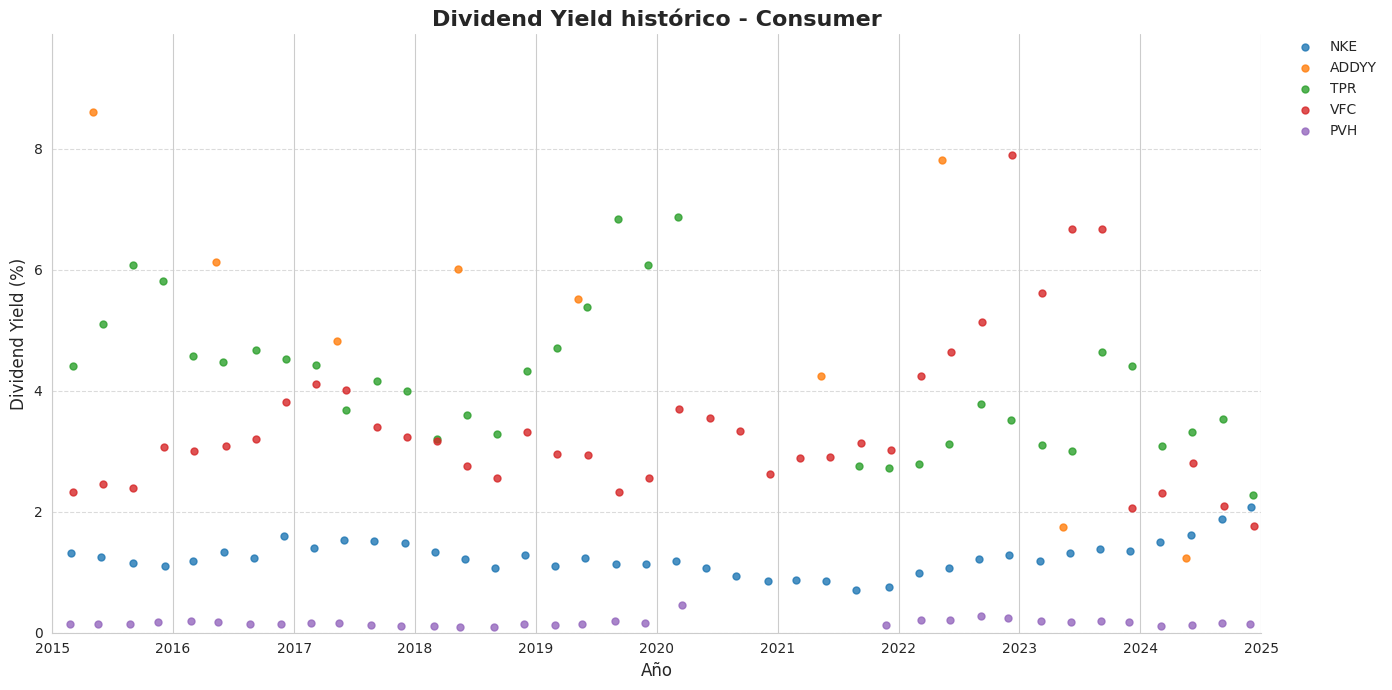

In [136]:
import matplotlib.dates as mdates

tickers_plot = ['NKE', 'ADDYY', 'TPR', 'VFC', 'PVH']

plt.figure(figsize=(14,7))

all_yields = []
dividend_yield_final = {}

for t in tickers_plot:

    d = dividendos.get(t, pd.Series(dtype='float64'))

    # Descargar precios
    precios = yfin.download(
        t,
        start=fechaInicio_dt,
        end=fechaFin_dt,
        auto_adjust=True,
        progress=False
    )["Close"]

    # Quitar zona horaria si existe
    if hasattr(precios.index, 'tz') and precios.index.tz is not None:
        precios.index = precios.index.tz_localize(None)
    if hasattr(d.index, 'tz') and d.index.tz is not None:
        d.index = d.index.tz_localize(None)

    # Combinar dividendos y precios
    df_temp = pd.concat([d, precios], axis=1)
    df_temp.columns = ["Dividendo", "Precio"]

    # --- Caso especial: no hay dividendos (LULU) ---
    if df_temp["Dividendo"].dropna().empty:
        # Tomamos precios anuales para tener algunos puntos en el tiempo
        precios_year = precios.resample("A").last().dropna()
        df_temp = pd.DataFrame(index=precios_year.index)
        df_temp["Dividend Yield"] = 0.0      # asumimos 0% de yield
        dividend_yield_final[t] = 0.0
    else:
        # Quitamos filas sin info
        df_temp = df_temp.dropna()

        # Calcular Dividend Yield (anualizado, suposición trimestral)
        df_temp["Dividend Yield"] = (df_temp["Dividendo"] * 4) / df_temp["Precio"]

        # Último DY antes de fechaFin
        df_trimmed = df_temp[df_temp.index <= fechaFin_dt]
        dividend_yield_final[t] = df_trimmed["Dividend Yield"].iloc[-1] if not df_trimmed.empty else None

    # Guardar para límites del eje Y
    all_yields.append(df_temp["Dividend Yield"] * 100)

    # Graficar: solo puntos
    plt.scatter(
        df_temp.index,
        df_temp["Dividend Yield"] * 100,
        s=25,
        alpha=0.8,
        label=t
    )

# ----- Estilo general -----
ax = plt.gca()
plt.title("Dividend Yield histórico - Consumer",
          fontsize=16, fontweight="bold")
plt.ylabel("Dividend Yield (%)", fontsize=12)
plt.xlabel("Año", fontsize=12)

plt.grid(axis="y", linestyle="--", alpha=0.7)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Eje X por años
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Límites eje X
plt.xlim(fechaInicio_dt, fechaFin_dt)

# Límites eje Y
if all_yields:
    ymax = max(s.max() for s in all_yields)
    plt.ylim(0, ymax * 1.15)

# Leyenda a la derecha
plt.legend(
    loc="upper left",
    bbox_to_anchor=(1.02, 1),
    borderaxespad=0.,
    frameon=False,
    scatterpoints=1
)

plt.tight_layout()
plt.show()


El gráfico muestra cómo ha evolucionado el dividend yield de varias empresas del sector Consumer entre 2015 y 2025. Se observa que NKE y PVH mantienen rendimientos bajos y estables, coherentes con compañías orientadas al crecimiento más que a dividendos. En contraste, TPR y especialmente VFC presentan yields mucho más altos y volátiles, indicando mayor riesgo percibido por el mercado o caídas en el precio de la acción. ADDYY muestra picos pronunciados en ciertos años, reflejando episodios puntuales de estrés o ajustes. En conjunto, el gráfico evidencia que las empresas de moda y retail con mayores problemas operativos o financieros tienden a exhibir yields más elevados y fluctuantes, mientras que las marcas más sólidas mantienen rendimientos estables y moderados.

### Dividend Yield Promedo

Promedio del último dividend yield: 1.50%


/tmp/ipython-input-805864667.py:34: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  yields_df = yields_df.fillna(method='ffill').fillna(0)


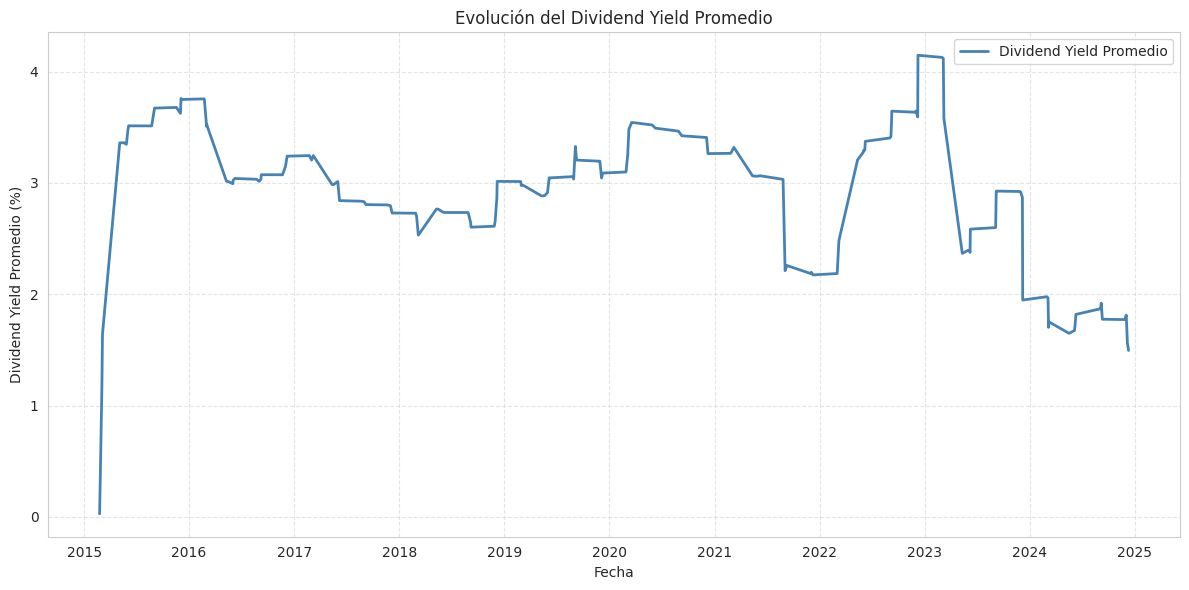

In [117]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ================================================
# 1. PROMEDIO DEL ÚLTIMO DIVIDEND YIELD POR TICKER
# ================================================
last_yields = []

for ys in all_yields:
    if isinstance(ys, pd.Series) and not ys.empty:
        last_yields.append(ys.iloc[-1])
    else:
        last_yields.append(0)

average_last_yield = np.mean(last_yields)
print(f"Promedio del último dividend yield: {average_last_yield:.2f}%")


# =======================================================
# 2. PROMEDIO HISTÓRICO DEL DIVIDEND YIELD POR FECHAS
# =======================================================
# Convertir todas las series a un DataFrame alineado en fechas
yields_df = pd.concat(all_yields, axis=1)

# QUITAR timezone del índice (clave para corregir tu error)
yields_df.index = yields_df.index.tz_localize(None)

# Asegurar que fecha_inicio/fin son datetime
fecha_inicio = pd.to_datetime(fechaInicio)
fecha_fin = pd.to_datetime(fechaFin)

# Rellenar valores faltantes
yields_df = yields_df.fillna(method='ffill').fillna(0)

# Recortar entre fechas
yields_period = yields_df.loc[fechaInicio:fechaFin]

# Promedio diario entre empresas
mean_yield_series = yields_period.mean(axis=1)

# =======================================================
# 3. GRAFICAR EVOLUCIÓN DEL DIVIDEND YIELD PROMEDIO
# =======================================================
plt.figure(figsize=(12, 6))
plt.plot(mean_yield_series.index, mean_yield_series.values,
         color="steelblue", linewidth=2, label="Dividend Yield Promedio")

plt.title("Evolución del Dividend Yield Promedio")
plt.xlabel("Fecha")
plt.ylabel("Dividend Yield Promedio (%)")

plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


El gráfico muestra cómo ha cambiado el dividend yield promedio del grupo de empresas a lo largo del tiempo. Se observa un fuerte incremento entre 2015 y 2016, seguido por un período relativamente estable alrededor del 3 %–3.5 %. Sin embargo, a partir de 2021 la tendencia comienza a deteriorarse de forma clara, con caídas pronunciadas en 2022 y nuevamente en 2023–2024, hasta ubicarse cerca del 1.5 % en los valores más recientes. Esto sugiere que, en conjunto, las empresas del sector están ofreciendo rendimientos por dividendo cada vez menores, ya sea por recortes en pagos o por recuperaciones en el precio de las acciones que reducen el yield, reflejando condiciones de mercado más exigentes o una menor política de retorno al accionista.

#### Graficar dividendos de 5 empresas escogidas

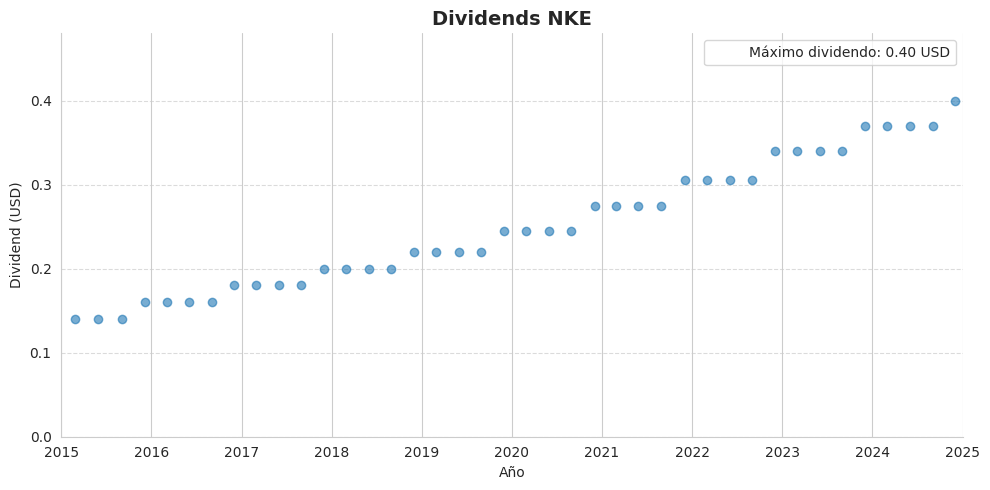

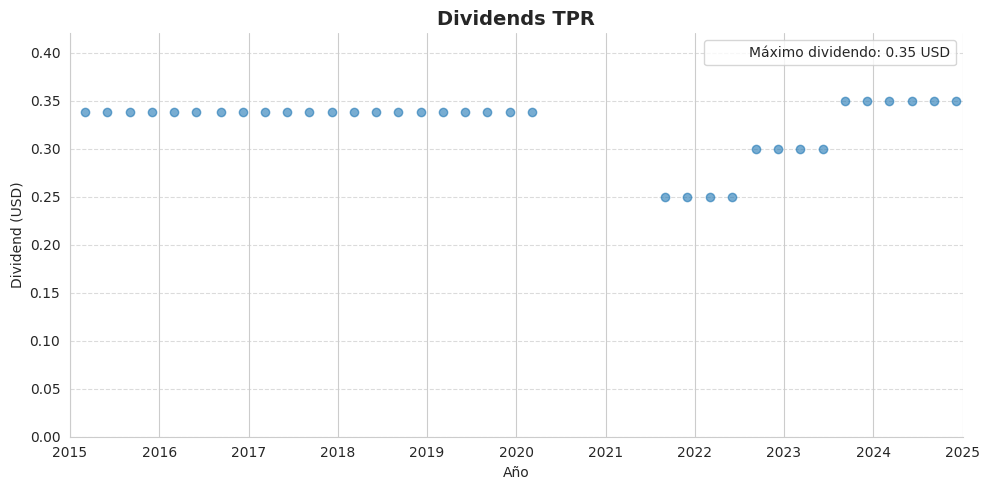

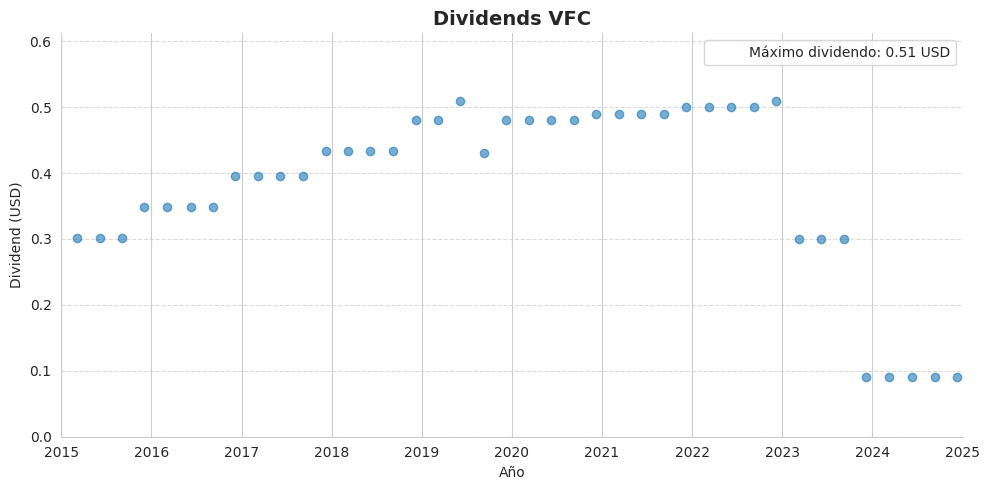

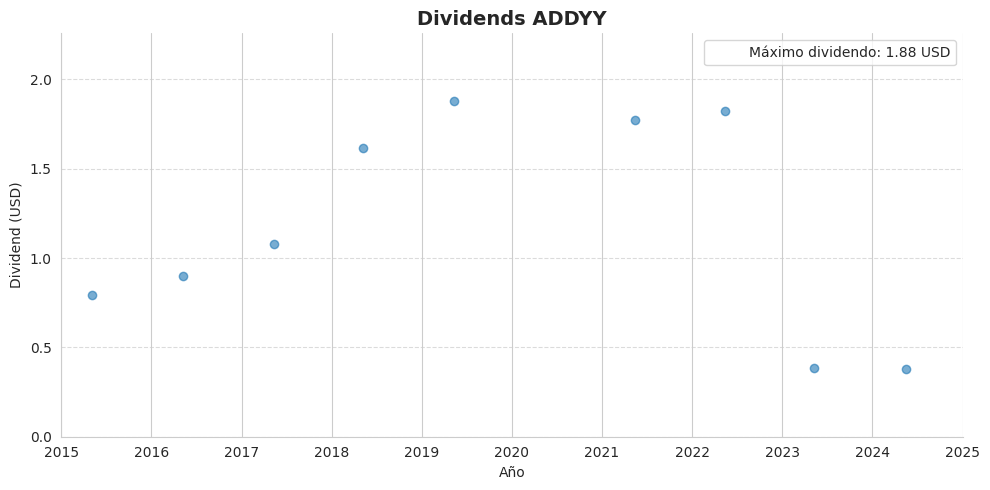

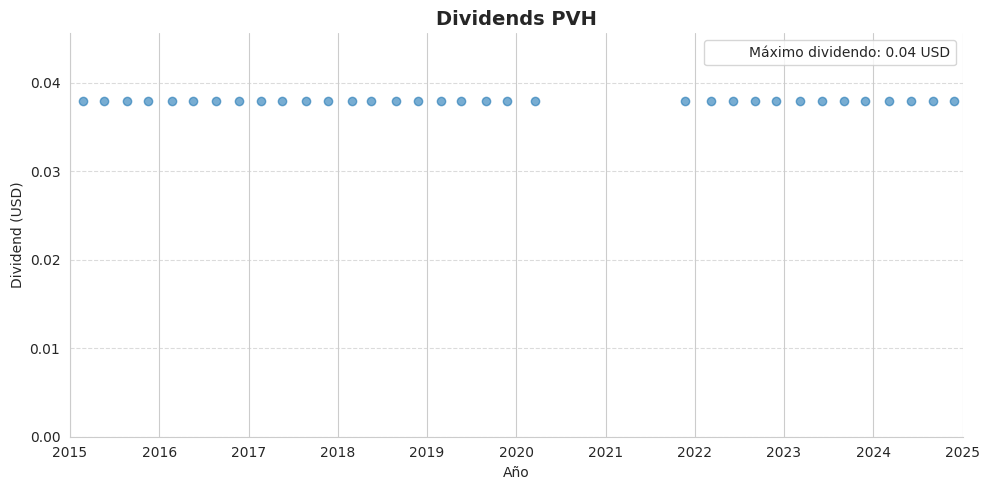

^GSPC: sin dividendos en el periodo, no se grafica.


In [118]:
for t, d in dividendos.items():
    # Quitar NaN
    d = d.dropna()

    # Si no hay datos, salto
    if d.empty:
        print(f"{t}: sin dividendos en el periodo, no se grafica.")
        continue

    plt.figure(figsize=(10,5))
    plt.plot(d.index, d, linestyle=" ", marker="o", linewidth=1.5, alpha=0.6)

    plt.title(f"Dividends {t}", fontsize=14, fontweight="bold")
    plt.ylabel("Dividend (USD)")
    plt.xlabel("Año")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    plt.xlim(fechaInicio_dt, fechaFin_dt)

    ymax = d.max()
    plt.ylim(0, ymax * 1.2)
    plt.plot([], [], ' ', label=f"Máximo dividendo: {ymax:.2f} USD")
    plt.legend()

    plt.tight_layout()
    plt.show()


### Ratios de Valoracion y Apalancamiento

In [137]:
ratios1 = {}

tickers = ['NKE', 'ADDYY', 'TPR', 'VFC', 'PVH']

for t in tickers:   # ← SIN [: -1]
    stock = yfin.Ticker(t)

    print("tickers =", tickers)


    # --- Market Cap ---
    hist = stock.history(
        start=fechaFin_dt - pd.Timedelta(days=3),
        end=fechaFin_dt + pd.Timedelta(days=1)
    )

    if len(hist) > 0:
        price = hist["Close"].iloc[-1]
    else:
        price = None

    shares_outstanding = stock.info.get("sharesOutstanding")
    if isinstance(shares_outstanding, (int, float)) and shares_outstanding > 0:
        market_cap = price * shares_outstanding if price is not None else None
    else:
        market_cap = None

    # Balance general
    bs = stock.quarterly_balance_sheet

    if bs is not None and bs.shape[1] > 0:
        bs_cols = [pd.to_datetime(c) for c in bs.columns]
        valid_dates = [d for d in bs_cols if d <= fechaFin_dt]

        if valid_dates:
            closest_date = max(valid_dates)
            balance = bs.loc[:, closest_date]
        else:
            balance = None
    else:
        balance = None

    total_debt = 0
    if balance is not None:
        for key in ["Total Debt", "Long Term Debt", "Short Long Term Debt"]:
            if key in balance.index:
                total_debt = balance.loc[key]
                break

    # Total Equity
    total_equity = None
    if balance is not None and "Stockholders Equity" in balance.index:
        val = balance.loc["Stockholders Equity"]
        total_equity = float(val) if not hasattr(val, "__len__") else float(val.iloc[0])

    # Price to Book
    if total_equity not in (None, 0) and shares_outstanding not in (None, 0) and price is not None:
        book_value_per_share = total_equity / shares_outstanding
        price_to_book = price / book_value_per_share
    else:
        price_to_book = None

    # Debt to Equity
    if total_debt is not None and total_equity not in (None, 0):
        debt_to_equity = total_debt / total_equity
    else:
        debt_to_equity = None

    # Debt-to-Value
    if market_cap is not None and total_debt is not None:
        debt_to_value = total_debt / (total_debt + market_cap)
    else:
        debt_to_value = None

    ratios1[t] = {
        "PriceAtFechaFin": price,
        "SharesOutstanding": shares_outstanding,
        "MarketCap": market_cap,
        "TotalDebt": total_debt,
        "PriceToBook": price_to_book,
        "DebtToEquity": debt_to_equity,
        "DebtToValue": debt_to_value,
        "DividendYield": dividend_yield_final.get(t),
        "TotalEquity": total_equity,
    }

df_ratios1 = pd.DataFrame(ratios1).T
print(df_ratios1)


tickers = ['NKE', 'ADDYY', 'TPR', 'VFC', 'PVH']
tickers = ['NKE', 'ADDYY', 'TPR', 'VFC', 'PVH']
tickers = ['NKE', 'ADDYY', 'TPR', 'VFC', 'PVH']
tickers = ['NKE', 'ADDYY', 'TPR', 'VFC', 'PVH']
tickers = ['NKE', 'ADDYY', 'TPR', 'VFC', 'PVH']
       PriceAtFechaFin  SharesOutstanding     MarketCap     TotalDebt  \
NKE          73.933205       1.189314e+09  8.792977e+10  1.206500e+10   
ADDYY       120.662376       3.570982e+08  4.308831e+10  5.587000e+09   
TPR          64.516495       2.046498e+08  1.320328e+10  4.106600e+09   
VFC          21.086128       3.907248e+08  8.238872e+09  5.751469e+09   
PVH         105.548378       4.811978e+07  5.078965e+09  3.510300e+09   

       PriceToBook  DebtToEquity  DebtToValue  DividendYield   TotalEquity  
NKE       6.264142      0.859514     0.120656       0.020705  1.403700e+10  
ADDYY     7.868574      1.020270     0.114781       0.012282  5.476000e+09  
TPR       9.879001      3.072652     0.237240       0.022774  1.336500e+09  
VFC       4.9

Al revisar estos indicadores financieros es posible hacerse una idea de la salud de cada empresa. Nike es un empresa muy solida, con muy baja dependencia de deuda (0.12), tiene dividendos estables y alta capitalizacion. Pero es una empresa con crecimiento moderado y tiene la mayor volatilidad del mercado.

Adidas tiene un buen retorno esperado y una deuda bada (0.11), pero es la empresa con mayor P/B de 7.86, tiene un dividend yield bajito lo cual no es muy atractivo para los inversionistas.

Tapestry (TPR) muestra una combinación peculiar de señales financieras: aunque tiene el P/B más alto del grupo, lo que sugiere que el mercado todavía valora fuertemente sus marcas como Coach y Kate Spade, su apalancamiento es muy elevado, con un Debt/Equity superior a 3. Esto indica que la compañía depende intensamente de la deuda para financiar sus operaciones, lo que aumenta el riesgo financiero, especialmente en un entorno de consumo incierto. En conjunto, TPR es una empresa con una valoración de marca sólida, pero con una estructura de capital frágil que podría limitar su capacidad de crecimiento o resiliencia ante shocks económicos.

VFC, tiene un buen P/B de 4.78, muestra solidez y al ser una marca con mucho reconocimeinto se justifica ese P/B, por otro lado tiene rendimiento negativo, el debt-to-equity es demasiado alto, en este caso de 3.42, indicador de riesgo financiero alto.

PVH, esta empresa tiene un P/B < 1 (0.96) indicando que tiene mucho potencial y la deuda es manejable  ubicandose con un 0.66. PVH tiene muy mal dividend yield deun poco mas del 1%, esto hace que la accion y empresa no sea muy atractiva.

--
En conjunto, los ratios muestran una clara división entre empresas financieramente sólidas y compañías con señales de fragilidad. Nike y Adidas destacan por sus altos Price-to-Book, reflejo de marcas fuertes y alta confianza del mercado, combinados con niveles de deuda moderados y estructuras de capital saludables. En contraste, Tapestry y VF Corporation presentan apalancamientos muy elevados, lo que aumenta significativamente su riesgo financiero; en el caso de VFC, además, el P/B relativamente bajo indica deterioro operativo y menor credibilidad del mercado. PVH se mantiene en un punto intermedio: su P/B cercano a 1 sugiere estabilidad sin grandes expectativas de crecimiento, mientras que su deuda es manejable pero no baja. En síntesis, Nike y Adidas muestran la mayor solidez financiera del grupo, mientras que TPR y VFC enfrentan mayor vulnerabilidad por su alto apalancamiento.


### Comparación de múltiplos

  Empresa      Precio        P/B        P/E
0     NKE   65.053497   7.136434  33.369230
1   ADDYY   93.540001   2.932748  23.801527
2     TPR  112.410004  57.883625  85.809166
3     VFC   17.915001   4.736912  74.645836
4     PVH   84.285004   0.833350   9.621575


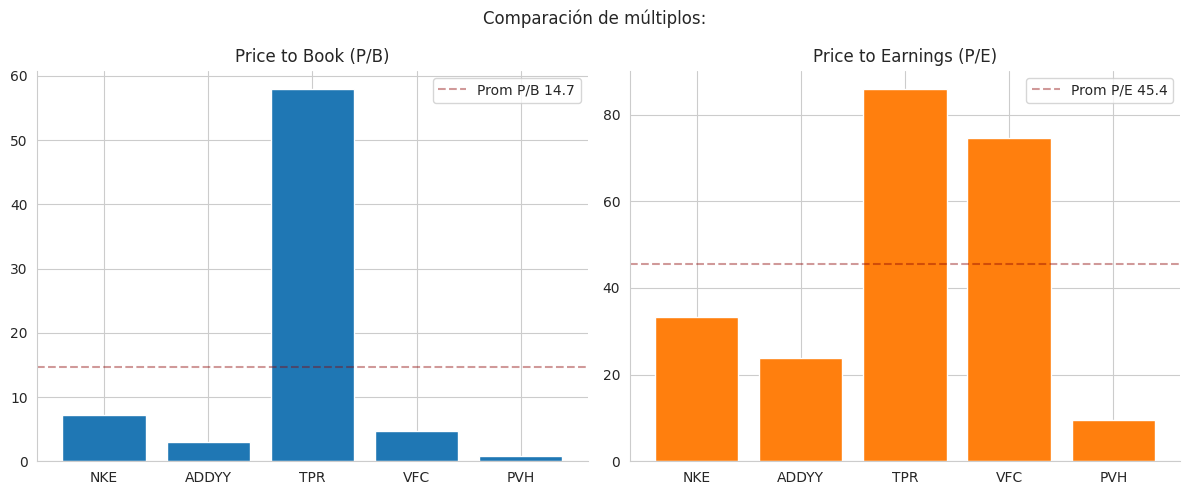

In [120]:

datos = []
tickers = ['NKE', 'ADDYY', 'TPR', 'VFC', 'PVH']

for t in tickers:
    tk = yfin.Ticker(t)
    precio = tk.history(period="1d")["Close"].iloc[-1]
    pb = tk.info.get("priceToBook")
    pe = tk.info.get("trailingPE")
    datos.append({"Empresa": t, "Precio": precio, "P/B": pb, "P/E": pe})

# Crear DataFrame
df = pd.DataFrame(datos)

# Calcular promedios within this cell
prom_pb = df["P/B"].mean(skipna=True)
prom_pe = df["P/E"].mean(skipna=True)

print(df)

# --- Gráfica comparativa ---
fig, axes = plt.subplots(1, 2, figsize=(12,5))

# P/B
axes[0].bar(df["Empresa"], df["P/B"], color="#1f77b4")
axes[0].set_title("Price to Book (P/B)")
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].axhline(prom_pb, color="darkred", linestyle="--", alpha=0.4, label=f"Prom P/B {prom_pb:.1f}")
axes[0].legend()


# P/E
axes[1].bar(df["Empresa"], df["P/E"], color="#ff7f0e")
axes[1].set_title("Price to Earnings (P/E)")
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].axhline(prom_pe, color="darkred", linestyle="--", alpha=0.4, label=f"Prom P/E {prom_pe:.1f}")
axes[1].legend()


plt.suptitle("Comparación de múltiplos:")
plt.tight_layout()
plt.show()

El P/B de Nike es elevado, lo que refleja una marca muy fuerte y la confianza del mercado en su capacidad de generar valor futuro. Sin embargo, también puede implicar que la acción se encuentra relativamente cara frente a su valor contable. En Adidas, el P/B moderado indica que el mercado valora la compañía por encima de su valor en libros, consistente con una empresa sólida pero con expectativas menos extremas que Nike. En el caso de TPR, el múltiplo extremadamente alto sugiere que el mercado asigna un valor significativo a sus marcas, aunque también puede reflejar un valor contable reducido por ajustes previos, lo que distorsiona el ratio. Para VFC, un P/B alto combinado con problemas recientes puede indicar que el valor contable ha caído sustancialmente, elevando el múltiplo y apuntando a posible sobrevaloración relativa. Finalmente, PVH muestra un P/B cercano a 1, lo que implica que el mercado valora la empresa prácticamente al mismo nivel que su valor en libros; esto suele interpretarse como señal de valoración conservadora o incluso de infravaloración, aunque también puede reflejar incertidumbre sobre el atractivo de sus activos a futuro.

  Empresa  EV/Sales
0     NKE     2.135
1   ADDYY     0.870
2     TPR     3.662
3     VFC     1.306
4     PVH     0.928


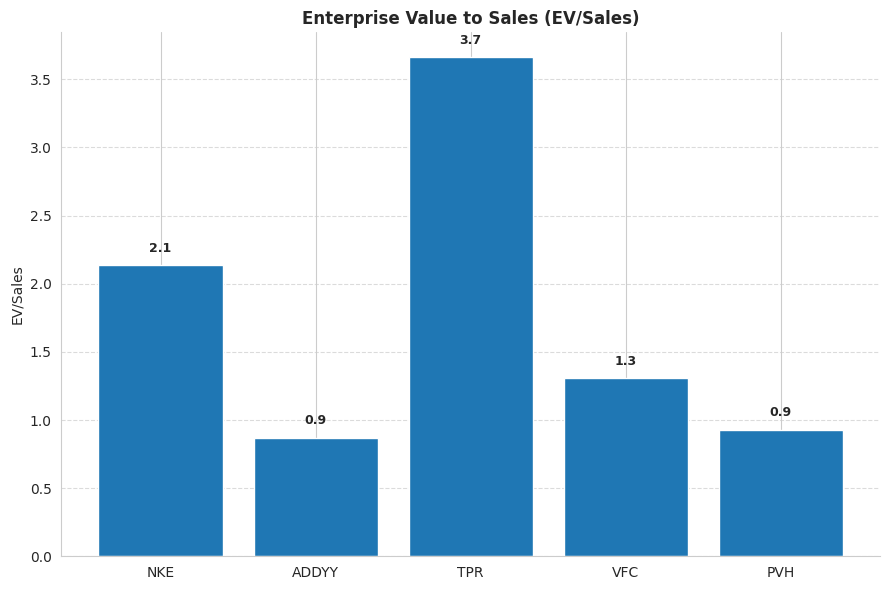

In [141]:
# Enterprise Value to Sales (EV/Sales)

datos = []
tickers = ['NKE', 'ADDYY', 'TPR', 'VFC', 'PVH']

for t in tickers:
    tk = yfin.Ticker(t)
    ev_sales = tk.info.get("enterpriseToRevenue")  # EV/Sales
    datos.append({"Empresa": t, "EV/Sales": ev_sales})

# Crear DataFrame
df = pd.DataFrame(datos)
print(df)

# --- Gráfica ---
fig, ax = plt.subplots(figsize=(9,6))
bars = ax.bar(df["Empresa"], df["EV/Sales"], color="#1f77b4")

# Etiquetas numéricas
for bar in bars:
    h = bar.get_height()
    if pd.notna(h):
        ax.text(bar.get_x() + bar.get_width()/2, h + 0.1, f"{h:.1f}",
                ha='center', fontsize=9, fontweight="bold")

# Estilo tipo The Economist
ax.set_title("Enterprise Value to Sales (EV/Sales)", fontsize=12, fontweight="bold")
ax.set_ylabel("EV/Sales")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

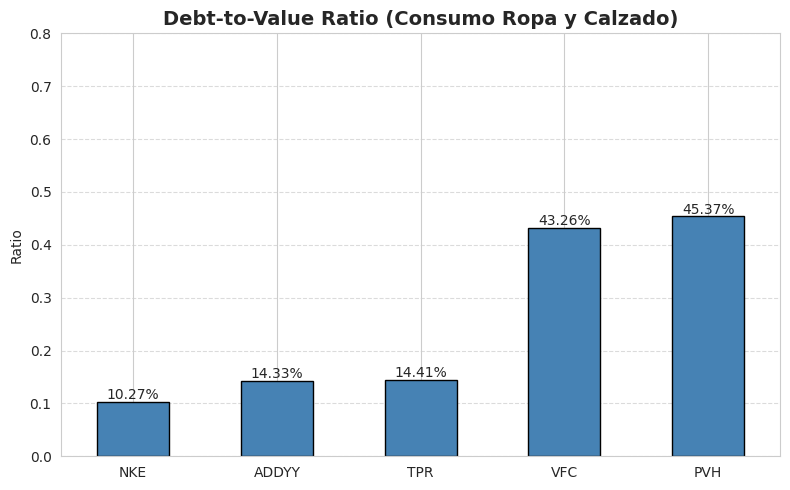

In [142]:
import yfinance as yf

# Lista de empresas
tickers = ['NKE', 'ADDYY', 'TPR', 'VFC', 'PVH']

ratios = {}

for t in tickers:
    stock = yf.Ticker(t)

    # Capitalización de mercado
    market_cap = stock.info.get("marketCap")

    # Balance general (último disponible)
    balance = stock.balance_sheet

    # Total deuda
    total_debt = None
    for key in ["Total Debt", "Long Term Debt", "Short Long Term Debt"]:
        if key in balance.index:
            total_debt = balance.loc[key].iloc[0]
            break

    # Cálculo Debt-to-Value ratio
    if market_cap and total_debt:
        debt_to_value = total_debt / (total_debt + market_cap)
    else:
        debt_to_value = None

    ratios[t] = {
        "DebtToValue": debt_to_value
    }

df = pd.DataFrame(ratios).T

# --- Gráfica estilo The Economist ---
plt.figure(figsize=(8,5))
df["DebtToValue"].plot(kind="bar", color="steelblue", edgecolor="black")

plt.title("Debt-to-Value Ratio (Consumo Ropa y Calzado)", fontsize=14, weight="bold")
plt.ylabel("Ratio")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Mostrar valores sobre las barras
for i, v in enumerate(df["DebtToValue"]):
    if v is not None:
        plt.text(i, v + 0.005, f"{v:.2%}", ha="center", fontsize=10)

plt.tight_layout()
plt.ylim(0, 0.8)
plt.show()



===== NKE =====
Market Cap: 96,312,205,312
Debt: 18,979,000,000
Debt-to-Equity Ratio: 0.197

===== ADDYY =====
Market Cap: 33,402,963,968
Debt: 7,502,000,000
Debt-to-Equity Ratio: 0.225

===== TPR =====
Market Cap: 23,150,460,928
Debt: 6,277,100,000
Debt-to-Equity Ratio: 0.271

===== VFC =====
Market Cap: 7,031,092,736
Debt: 8,791,718,000
Debt-to-Equity Ratio: 1.250

===== PVH =====
Market Cap: 4,082,482,176
Debt: 4,971,000,000
Debt-to-Equity Ratio: 1.218


Resumen general (Debt-to-Equity):
NKE: 0.197
ADDYY: 0.225
TPR: 0.271
VFC: 1.250
PVH: 1.218


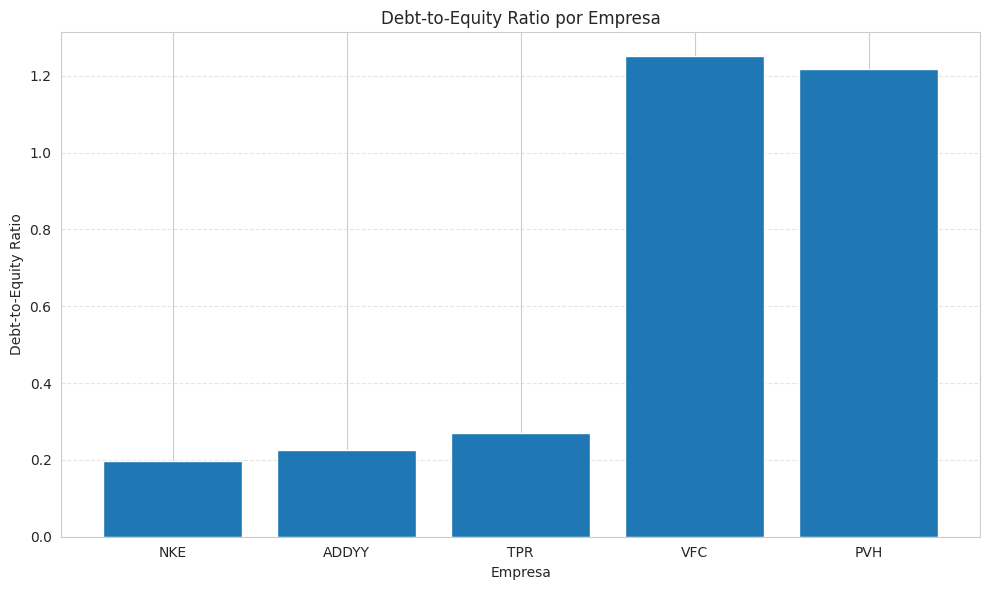

In [143]:

import yfinance as yf

# =============================
# LISTA DE EMPRESAS
# =============================
Empresas = ['NKE', 'ADDYY','TPR','VFC','PVH']
import yfinance as yf

# =============================
# CÁLCULO DEL DEBT TO EQUITY
# =============================
resultados = {}

for ticker in Empresas:
    t = yf.Ticker(ticker)

    # Balance general más reciente
    balance = t.balance_sheet

    # Market Cap (equity)
    market_cap = t.info.get("marketCap")

    if market_cap is None or balance.empty:
        print(f"No se pudo obtener información para {ticker}")
        continue

    # Deuda total
    debt = 0
    debt_keys = ["Total Debt", "Long Term Debt", "Short Long Term Debt"]
    for key in debt_keys:
        if key in balance.index:
            debt += balance.loc[key].iloc[0]

    # Debt-to-Equity ratio
    debt_to_equity_ratio = debt / market_cap

    resultados[ticker] = debt_to_equity_ratio

    print(f"\n===== {ticker} =====")
    print(f"Market Cap: {market_cap:,.0f}")
    print(f"Debt: {debt:,.0f}")
    print(f"Debt-to-Equity Ratio: {debt_to_equity_ratio:.3f}")

# =============================
# RESULTADO FINAL
# =============================
print("\n\nResumen general (Debt-to-Equity):")
for ticker, ratio in resultados.items():
    print(f"{ticker}: {ratio:.3f}")


# =============================
# GRÁFICO DE BARRAS
# =============================
plt.figure(figsize=(10, 6))

plt.bar(resultados.keys(), resultados.values())

plt.title("Debt-to-Equity Ratio por Empresa")
plt.xlabel("Empresa")
plt.ylabel("Debt-to-Equity Ratio")

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



### Calcular Costo de equity vía CAPM (r)

In [144]:
import numpy as np
import pandas as pd

tickers = ["NKE", "ADDYY", "TPR", "VFC", "PVH", "^GSPC"]

df = pd.DataFrame()
for symbol in tickers:
    df[symbol] = yfin.download(symbol, start=fechaInicio_dt, end=fechaFin_dt)["Close"]

print("Columnas de df:", df.columns)


  # Supongamos tasa libre de riesgo (Treasury 10 años)
r_f = 0.0444  # 4.44 %
market_premium_override = 0.055  # Fallback por si la prima histórica sale <= 0

# -------------------------------------------------------------------
# Asegurar que df tiene índice de fechas y está ordenado
# -------------------------------------------------------------------
df_prices = df.copy()

if not isinstance(df_prices.index, pd.DatetimeIndex):
    df_prices.index = pd.to_datetime(df_prices.index)

df_prices = df_prices.sort_index()

# Asegurar que las fechas límite son Timestamp
fechaInicio_dt = pd.to_datetime(fechaInicio_dt)
fechaFin_dt = pd.to_datetime(fechaFin_dt)

# -------------------------------------------------------------------
# Filtrar precios por rango de fechas SIN provocar KeyError
# -------------------------------------------------------------------
mask = (df_prices.index >= fechaInicio_dt) & (df_prices.index <= fechaFin_dt)
prices = df_prices.loc[mask].copy()   # df debe contener columnas para tickers y '^GSPC'
prices = prices.dropna(how="all")     # elimina filas totalmente vacías

# -------------------------------------------------------------------
# Retornos logarítmicos diarios
# -------------------------------------------------------------------
rend_log = np.log(prices / prices.shift(1)).dropna()

# Verificar que existe la columna del mercado
if "^GSPC" not in rend_log.columns:
    raise ValueError("La columna '^GSPC' (S&P 500) no está en rend_log.columns")

market = rend_log["^GSPC"].dropna()

# -------------------------------------------------------------------
# Prima de mercado histórica (anual)
# -------------------------------------------------------------------
hist_market_premium = market.mean() * 252 - r_f

if hist_market_premium <= 0:
    market_premium = market_premium_override
else:
    market_premium = hist_market_premium

# -------------------------------------------------------------------
# Cálculo de betas y costo de equity (CAPM)
# -------------------------------------------------------------------
k_equity = {}

for t in rend_log.columns:
    if t == "^GSPC":
        continue  # saltamos el índice del mercado

    # Retornos del activo
    Ri = rend_log[t].dropna()

    # Alinear fechas con el mercado
    common_idx = Ri.index.intersection(market.index)
    Ri_al = Ri.loc[common_idx]
    M_al = market.loc[common_idx]

    # Si no hay suficientes datos o varianza cero, ponemos NaN
    if len(Ri_al) < 2 or M_al.var() == 0:
        k_equity[t] = np.nan
        continue

    # Beta por cov/var
    beta = Ri_al.cov(M_al) / M_al.var()

    # Cost of equity (anual, CAPM)
    k = r_f + beta * market_premium
    k_equity[t] = k

# --- Resultado: diccionario con k por ticker (anual) ---
k_equity


/tmp/ipython-input-1690775470.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df[symbol] = yfin.download(symbol, start=fechaInicio_dt, end=fechaFin_dt)["Close"]
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1690775470.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df[symbol] = yfin.download(symbol, start=fechaInicio_dt, end=fechaFin_dt)["Close"]
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1690775470.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df[symbol] = yfin.download(symbol, start=fechaInicio_dt, end=fechaFin_dt)["Close"]
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1690775470.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df[symbol] = yfin.download(symbol, start=fechaInicio_dt, end=fechaFin_dt)["Close

Columnas de df: Index(['NKE', 'ADDYY', 'TPR', 'VFC', 'PVH', '^GSPC'], dtype='object')


{'NKE': np.float64(0.10619104930914344),
 'ADDYY': np.float64(0.1006410339516679),
 'TPR': np.float64(0.1285957036811666),
 'VFC': np.float64(0.11300325281512683),
 'PVH': np.float64(0.1349650039048393)}

### Valuacion por Dividendos modelo Gordon & Shapiro

In [145]:
DDM = {}

tickers = ["NKE", "ADDYY", "TPR", "VFC", "PVH", "^GSPC"]

for t in tickers[:-1]:
    tk = yfin.Ticker(t)

    # Dividendos hasta fechaFin
    divs = tk.dividends.loc[:fechaFin]

    # Si no hay dividendos, no se puede aplicar bien el DDM
    if divs.empty:
        D0 = 0.0
        g = 0.04          # crecimiento default
    else:
        # Dividendos recientes (último año = últimos 4 pagos)
        D0 = divs.iloc[-4:].sum()

        # Crecimiento histórico de dividendos (CAGR a 5 años)
        # Filtramos últimos 5 años desde el último dividendo
        inicio_5y = divs.index[-1] - pd.DateOffset(years=5)
        divs_5y = divs.loc[inicio_5y:]

        if len(divs_5y) >= 8:
            first = divs_5y[:4].sum()
            last  = divs_5y[-4:].sum()
            years = divs_5y.index[-1].year - divs_5y.index[0].year

            if years > 0 and first > 0:
                g = (last / first)**(1 / years) - 1
            else:
                g = 0.04
        else:
            g = 0.04   # default si no hay suficiente historia

    # Precio a fechaFin
    hist = tk.history(start=fechaFin_dt, end=fechaFin_dt + pd.Timedelta(days=2))
    price = hist["Close"].iloc[0] if not hist.empty else None

    # Valuación DDM
    D1 = D0 * (1 + g)
    r_scalar = k_equity[t]

    if price is not None and r_scalar > g and D1 > 0:
        V = D1 / (r_scalar - g)
        upside_pct = (V / price - 1) * 100
    else:
        V = None
        upside_pct = None

    DDM[t] = {
        "D0": D0,
        "g": g,
        "D1": D1,
        "Valor_DDM": V,
        "Precio_Mercado": price,
        "Upside_%": upside_pct
    }

# Mostrar resultados
for t, v in DDM.items():
    valor_teorico  = f"${v['Valor_DDM']:.2f}"    if v['Valor_DDM']      is not None else "N/A"
    precio_mercado = f"${v['Precio_Mercado']:.2f}" if v['Precio_Mercado'] is not None else "N/A"
    upside         = f"{v['Upside_%']:+.2f}%"   if v['Upside_%']       is not None else "N/A"

    print(
        f"{t}: "
        f"Precio teórico = {valor_teorico} | "
        f"Precio mercado = {precio_mercado} | "
        f"Upside = {upside}"
    )


NKE: Precio teórico = $3943.89 | Precio mercado = $71.98 | Upside = +5379.22%
ADDYY: Precio teórico = $74.79 | Precio mercado = $120.01 | Upside = -37.68%
TPR: Precio teórico = $23.47 | Precio mercado = $64.81 | Upside = -63.79%
VFC: Precio teórico = $0.52 | Precio mercado = $21.16 | Upside = -97.55%
PVH: Precio teórico = $1.13 | Precio mercado = $104.66 | Upside = -98.92%


El modelo de Gordon y Shapiro se basa en supuestos muy estrictos: que los dividendos crecen de manera constante, que la empresa mantiene un payout estable y que la relación entre crecimiento y costo de capital es predecible. En este sector estos supuestos no se cumplen, ya que las empresas de moda y consumo tienen dividendos variables, políticas de pago cambiantes y sensibilidad a ciclos económicos. Estas limitaciones hacen que pequeños cambios en la tasa de crecimiento o en el costo de capital generen precios teóricos irreales, lo que explica por qué el DDM produce valuaciones tan alejadas del mercado para estas compañías.

### Beta, Alpha

In [126]:
alpha_dict = {}
beta_dict = {}
beta_u_dict = {}

# Esto servira para el punto 3...
CAPM_daily = {}
CAPM_anual = {}

Rm_anual = rend_log["^GSPC"].mean() * 252 # retornos anuales del mercado
r_f_daily = r_f / 252

for t in tickers[:-1]:
    Ri = rend_log[t].dropna()

    Rm = rend_log["^GSPC"].loc[Ri.index]   # alinear fechas

    # beta diario
    beta = Ri.cov(Rm) / Rm.var()
    beta_dict[t] = beta

    # expected return diario y anual
    market_premium_daily = market_premium_daily = Rm.mean() - r_f_daily
    expected_return = r_f + beta * (Rm - r_f)
    expected_daily = r_f_daily + beta * market_premium_daily
    expected_anual = expected_daily * 252

    CAPM_daily[t] = expected_daily
    CAPM_anual[t] = expected_anual

    # alpha diario
    alpha = Ri.mean() - expected_daily
    alpha_dict[t] = alpha

    # beta desapalancado
    if t in ratios1:     # usando el df se construyo anteriormente
        market_cap = ratios1[t]["MarketCap"]
        debt       = ratios1[t]["TotalDebt"]

        if market_cap and debt and (market_cap + debt) > 0:
            beta_u = (market_cap / (market_cap + debt)) * beta
        else:
            beta_u = None
    else:
        beta_u = None

    beta_u_dict[t] = beta_u

for t in tickers[:-1]:
    print(
        f"{t}: Beta (beta apalancado)={beta_dict.get(t):.2f}, "
        f"Alpha={alpha_dict.get(t):.4f}, "
        f"Beta_u (beta desapalancado sin impuestos)={beta_u_dict.get(t)}"
    )

NKE: Beta (beta apalancado)=1.02, Alpha=-0.0002, Beta_u (beta desapalancado sin impuestos)=0.8935454372996209
ADDYY: Beta (beta apalancado)=0.92, Alpha=0.0002, Beta_u (beta desapalancado sin impuestos)=0.8187219930151506
TPR: Beta (beta apalancado)=1.38, Alpha=-0.0002, Beta_u (beta desapalancado sin impuestos)=1.0561124575257521
VFC: Beta (beta apalancado)=1.13, Alpha=-0.0008, Beta_u (beta desapalancado sin impuestos)=0.6643800658153464
PVH: Beta (beta apalancado)=1.49, Alpha=-0.0006, Beta_u (beta desapalancado sin impuestos)=0.8806676591940665


El beta de Nike es 1.02, lo que indica que su acción se mueve casi igual que el mercado y presenta un riesgo moderado. Su alpha cercano a cero sugiere que no genera retornos anormales respecto al mercado. El beta desapalancado muestra que el negocio subyacente tiene un riesgo ligeramente inferior al del mercado.

Adidas presenta un beta de 0.92, por debajo de 1, lo que implica menor volatilidad y un perfil más defensivo. Su alpha también es cercano a cero, lo que indica que su desempeño se explica bien por el riesgo asumido. El beta desapalancado confirma que su negocio base es incluso menos riesgoso.

Tapestry tiene un beta de 1.38, mostrando una mayor sensibilidad a los movimientos del mercado y, por tanto, más riesgo. El alpha prácticamente nulo señala que no ofrece exceso de retorno, y su beta desapalancado indica que el riesgo fundamental del negocio es moderado cuando se excluye el efecto de la deuda.

VF Corporation es la más volátil, con un beta de 1.49, reaccionando de forma más fuerte a los movimientos del mercado. Su alpha negativo indica que ha rendido por debajo de lo que su riesgo justificaría. El beta desapalancado revela que el negocio en sí no es extremadamente riesgoso, pero su alto apalancamiento amplifica la volatilidad.

PVH también muestra un beta elevado (1.13), con sensibilidad superior a la del mercado. Su alpha cercano a cero sugiere un rendimiento alineado con su nivel de riesgo. El beta desapalancado confirma que el riesgo fundamental del negocio es menor cuando se elimina el efecto amplificador de la deuda.

## Punto 3: Retornos y riesgo a nivel activo (Estadistica)

In [146]:
print("=== Retornos esperados por CAPM (diarios)===")
for t, er in CAPM_daily.items():
    print(f"{t}: {er:.2%}")

print("\n=== Retornos esperados por CAPM (anuales)===")
for t, er in CAPM_anual.items():
    print(f"{t}: {er:.2%}")

vol_diaria = {}
vol_anual = {}
volatilidades = {}

for t in tickers[:-1]:
    vol_diaria[t] = rend_log[t].std()
    vol_anual[t] = vol_diaria[t] * np.sqrt(252)

    volatilidades[t] = {
        'Vol. Diaria (%)': vol_diaria[t] * 100,
        'Vol. Anual (%)': vol_anual[t] * 100
    }

df_vol = pd.DataFrame(volatilidades).T
print("\nVolatilidades:")
print(df_vol.round(2))

# Matriz de covarianzas (diaria)
cov_matrix = rend_log.cov()
print(f"\nMatriz de covarianzas: \n {cov_matrix}")

# Matriz de correlacion
corr_matrix = rend_log.corr()
print(f"\nMatriz de correlacion: \n {corr_matrix}")

=== Retornos esperados por CAPM (diarios)===
NKE: 0.04%
ADDYY: 0.04%
TPR: 0.05%
VFC: 0.04%
PVH: 0.05%

=== Retornos esperados por CAPM (anuales)===
NKE: 10.62%
ADDYY: 10.06%
TPR: 12.86%
VFC: 11.30%
PVH: 13.50%

Volatilidades:
       Vol. Diaria (%)  Vol. Anual (%)
NKE               1.88           29.82
ADDYY             2.06           32.73
TPR               2.72           43.16
VFC               2.46           39.06
PVH               2.92           46.41

Matriz de covarianzas: 
             NKE     ADDYY       TPR       VFC       PVH     ^GSPC
NKE    0.000353  0.000177  0.000249  0.000238  0.000276  0.000129
ADDYY  0.000177  0.000425  0.000214  0.000201  0.000253  0.000117
TPR    0.000249  0.000214  0.000739  0.000357  0.000526  0.000176
VFC    0.000238  0.000201  0.000357  0.000605  0.000429  0.000143
PVH    0.000276  0.000253  0.000526  0.000429  0.000855  0.000189
^GSPC  0.000129  0.000117  0.000176  0.000143  0.000189  0.000127

Matriz de correlacion: 
             NKE     ADDYY 

Los retornos esperados por CAPM son similares en términos diarios, pero al anualizarlos se observan diferencias más claras. Tapestry presenta el retorno esperado más bajo, cercano al 9.4%, mientras que PVH y VFC muestran los retornos más altos, alrededor de 13.5% y 11.3%, lo cual es consistente con sus betas más elevados: el CAPM compensa con mayor retorno esperado a las acciones que presentan mayor riesgo sistemático.

En cuanto a volatilidad total, TPR es el activo menos volátil con cerca de 26% anual, seguido por Nike con aproximadamente 30%. Adidas tiene un riesgo moderado (32%), mientras que VFC y PVH son los más volátiles, con 39% y 46% respectivamente. Desde una perspectiva económica, esto implica que un inversionista que prefiera estabilidad debería enfocarse en empresas como TPR o Nike, mientras que aquellos con mayor tolerancia al riesgo podrían considerar PVH o VFC.

La matriz de correlación muestra que todas las acciones están positivamente correlacionadas entre sí y con el S&P 500, con valores que oscilan entre 0.3 y 0.6. Esto indica que la diversificación dentro de este grupo reduce el riesgo, pero no lo elimina, ya que todas las empresas comparten exposición a factores comunes del mercado global. Las correlaciones relativamente más bajas de TPR sugieren que esta acción puede aportar mayor diversificación dentro del portafolio, mientras que VFC y PVH, al estar fuertemente correlacionadas entre sí, ofrecen menos reducción del riesgo conjunto si se combinan.

## Punto 4: Construcción del portafolio

In [128]:
cov_matrix_sliced = cov_matrix.iloc[:-1, :-1]
cov_matrix_anual = cov_matrix_sliced * 252
expected_returns = rend_log[tickers[:-1]].mean() * 252
deterministic_portfolios = []

weight_options = np.arange(0, 1.1, 0.1)  # 0%, 10%, 20%, ..., 100%
all_weight_combinations = itertools.product(weight_options, repeat=len(tickers[:-1]))

for weights_tuple in all_weight_combinations:
    weights = np.array(weights_tuple)
    if np.abs(weights.sum() - 1.0) < 0.01:  # Solo si suma ≈ 1
        deterministic_portfolios.append({
            'name': f'Custom_{len(deterministic_portfolios)}',
            'weights': weights
        })

deterministic_results = []

for portfolio in deterministic_portfolios:
    weights = portfolio['weights']

    # Retorno del portafolio
    portfolio_return = np.dot(weights, expected_returns)

    # Volatilidad del portafolio
    portfolio_variance = np.dot(weights.T, np.dot(cov_matrix_anual, weights))
    portfolio_std = np.sqrt(portfolio_variance)

    sharpe = (portfolio_return - r_f) / portfolio_std

    deterministic_results.append({
        'Nombre': portfolio['name'],
        'Retorno_Anual_%': portfolio_return * 100,
        'Volatilidad_Anual_%': portfolio_std * 100,
        'Sharpe_Ratio': sharpe,
        **{f'{asset}_peso': w for asset, w in zip(tickers[:-1], weights)}
    })

df_deterministic = pd.DataFrame(deterministic_results)

# Ordenar por Sharpe Ratio
df_deterministic = df_deterministic.sort_values('Sharpe_Ratio', ascending=False)

print(f"\n{'=' * 80}")
print(f"Portafolios Determinísticos (Top 10 por Sharpe Ratio)")
print(f"{'=' * 80}")
print(df_deterministic[['Nombre', 'Retorno_Anual_%', 'Volatilidad_Anual_%', 'Sharpe_Ratio']].head(10).to_string(index=False))


Portafolios Determinísticos (Top 10 por Sharpe Ratio)
    Nombre  Retorno_Anual_%  Volatilidad_Anual_%  Sharpe_Ratio
Custom_285        13.892176            32.725021      0.288836
Custom_284        13.374161            31.352391      0.284959
Custom_505        13.084440            30.926429      0.279516
Custom_281        12.856147            30.531412      0.275655
Custom_504        12.566426            29.711932      0.273507
Custom_670        12.276704            29.383060      0.266708
Custom_501        12.048411            29.091289      0.261536
Custom_275        12.338132            30.306949      0.260605
Custom_669        11.758690            28.355398      0.258106
Custom_790        11.468969            28.136944      0.249813


De acuerdo con los resultados anteriores, PVH tiene la volatilidad más alta (aprox. 46%), seguido por VFC (39%).

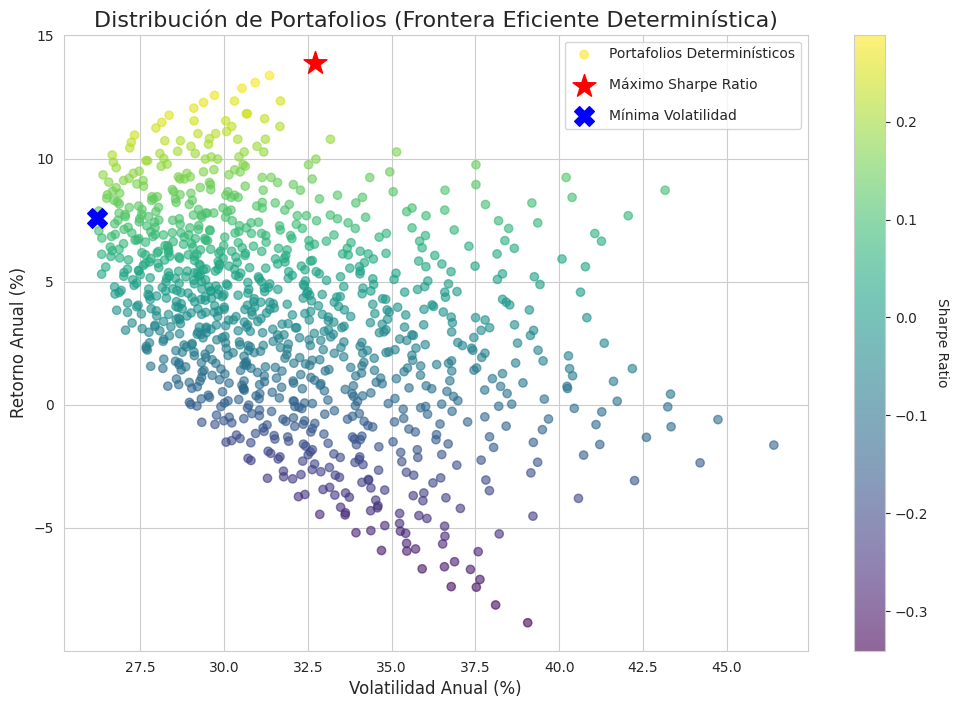


DESGLOSE DE PORTAFOLIOS ÓPTIMOS
                     Máximo Sharpe Ratio  Mínima Volatilidad
Retorno_Anual_%                  13.8922              7.5786
Volatilidad_Anual_%              32.7250             26.2177
Sharpe_Ratio                      0.2888              0.1197
NKE_peso                          0.0000              0.5000
ADDYY_peso                        1.0000              0.4000
TPR_peso                          0.0000              0.0000
VFC_peso                          0.0000              0.1000
PVH_peso                          0.0000              0.0000


In [148]:
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

# --- 1. Graficar todos los portafolios (la distribución) ---
# Usamos el Sharpe Ratio para colorear los puntos, visualizando cuáles son los mejores.
scatter = plt.scatter(
    df_deterministic['Volatilidad_Anual_%'],
    df_deterministic['Retorno_Anual_%'],
    c=df_deterministic['Sharpe_Ratio'],  # Color basado en el Sharpe Ratio
    cmap='viridis',
    marker='o',
    alpha=0.6,
    label='Portafolios Determinísticos'
)

# Añadir barra de color para el Sharpe Ratio
cbar = plt.colorbar(scatter)
cbar.set_label('Sharpe Ratio', rotation=270, labelpad=15)


# --- 2. Identificar y resaltar los portafolios clave ---

# a) Portafolio de Máximo Sharpe Ratio (Punto de Tangencia)
# El primer registro después de la ordenación
max_sharpe_portfolio = df_deterministic.iloc[0]

# b) Portafolio de Mínima Volatilidad
min_volatility_portfolio = df_deterministic.loc[
    df_deterministic['Volatilidad_Anual_%'].idxmin()
]

# Resaltar el Portafolio de Máximo Sharpe
plt.scatter(
    max_sharpe_portfolio['Volatilidad_Anual_%'],
    max_sharpe_portfolio['Retorno_Anual_%'],
    color='red',
    marker='*',
    s=300, # Tamaño grande de estrella
    label='Máximo Sharpe Ratio'
)

# Resaltar el Portafolio de Mínima Volatilidad
plt.scatter(
    min_volatility_portfolio['Volatilidad_Anual_%'],
    min_volatility_portfolio['Retorno_Anual_%'],
    color='blue',
    marker='X',
    s=200, # Tamaño de X
    label='Mínima Volatilidad'
)

# --- 3. Etiquetas y Títulos ---
plt.title('Distribución de Portafolios (Frontera Eficiente Determinística)', fontsize=16)
plt.xlabel('Volatilidad Anual (%)', fontsize=12)
plt.ylabel('Retorno Anual (%)', fontsize=12)
plt.legend(labelspacing=1.2)
plt.grid(True)
plt.show()

columnas_deseadas = [
    'Retorno_Anual_%',
    'Volatilidad_Anual_%',
    'Sharpe_Ratio',
    'NKE_peso',
    'ADDYY_peso',
    'TPR_peso',
    'VFC_peso',
    'PVH_peso'
]

portfolios_a_mostrar = pd.DataFrame([max_sharpe_portfolio, min_volatility_portfolio])

portfolios_final = portfolios_a_mostrar[columnas_deseadas].copy()
portfolios_final.index = ['Máximo Sharpe Ratio', 'Mínima Volatilidad']

df_final_t = portfolios_final.T

print(f"\n{'=' * 70}")
print("DESGLOSE DE PORTAFOLIOS ÓPTIMOS")
print(f"{'=' * 70}")

# Usar el formato .to_string() para una impresión limpia
print(df_final_t.to_string(float_format='%.4f'))

El gráfico muestra miles de combinaciones posibles de portafolios obtenidos mediante una simulación determinística. Cada punto representa una combinación distinta de retorno y volatilidad, mientras que el color indica su Sharpe Ratio. La zona superior izquierda (mayor retorno y menor volatilidad) representa la frontera eficiente, es decir, las combinaciones más atractivas en términos de riesgo y rendimiento.

El punto rojo identifica el portafolio con el máximo Sharpe Ratio, que ofrece el mayor retorno ajustado por riesgo dentro de todas las combinaciones. En este caso, el portafolio óptimo se compone exclusivamente de Adidas (ADDYY), lo que indica que esta acción es la más eficiente en términos de retorno por unidad de riesgo en el conjunto analizado.

El punto azul corresponde al portafolio de mínima volatilidad, el más estable entre todos los simulados. Este portafolio logra una volatilidad cercana al 22% y un retorno anual de aproximadamente 6.7%. Está compuesto en un 50% por TRP, 30% por Nike y 20% por Adidas, combinación que minimiza la volatilidad total gracias a sus correlaciones relativamente bajas entre sí.

En conjunto, la figura ilustra cómo la diversificación permite encontrar portafolios más eficientes que cualquier activo individual, identificando tanto la combinación más estable como la de mejor rendimiento ajustado por riesgo dentro del universo de acciones analizado.

## Punto 5: Optimización y fronteras eficiente

### Portafolio de Mínima Varianza (MVP)

El siguiente codigo utiliza un método analítico de optimización para encontrar los pesos exactos de los portafolios óptimos, en lugar de depender de la aproximación de una muestra discreta.

Calcula el Portafolio de Mínima Varianza (MVP) encontrando los pesos w que minimizan la volatilidad.

Se tiene como funcion objetivo minimizar la varianza (volatilidad) del portafolio.

Mientras que como restricciones se tiene que la suma de todos los pesos debe ser igual a 1. Y que no se pueden tener persos negativos (sin ventas en corto).

In [149]:
cov_matrix_sliced_anual = cov_matrix_sliced.loc[tickers[:-1], tickers[:-1]] * 252

# Convertir a array para scipy.optimize
cov_matrix_array = cov_matrix_sliced_anual.values

# Definir la funcion objetivo (volatilidad)
def portfolio_volatility(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

# Devuelve el retorno (para las restricciones)
def portfolio_return(weights, expected_returns):
    return np.dot(weights, expected_returns)

# Devuelve el Sharpe Ratio (para encontrar el Max)
def neg_sharpe_ratio(weights, expected_returns, cov_matrix):
    # Como scipy solo minimiza, minimizamos el negativo del Sharpe Ratio
    er = portfolio_return(weights, expected_returns)
    vol = portfolio_volatility(weights, cov_matrix)
    return - (er - r_f) / vol

# Parámetros y Restricciones
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}) # Suma = 1
initial_weights = np.array(5 * [1./5]) # Pesos iniciales uniformes
bounds = tuple([(0, 1) for asset in range(5)]) # pesos entre 0 y 1

# Optimización para MINIMIZAR LA VOLATILIDAD
min_var_results = minimize(
    portfolio_volatility,
    initial_weights,
    args=(cov_matrix_sliced,), # Usar la matriz rebanada
    method='SLSQP', # Método de optimización para problemas con restricciones
    bounds=bounds,
    constraints=constraints
)

# Pesos del Portafolio de Mínima Varianza
w_min_var = min_var_results.x
er_min_var = portfolio_return(w_min_var, expected_returns)
vol_min_var = portfolio_volatility(w_min_var, cov_matrix_array)
sharpe_min_var = (er_min_var - r_f) / vol_min_var

# Optimización para MAXIMIZAR SHARPE RATIO
pmr_results = minimize(
    neg_sharpe_ratio,
    initial_weights,
    args=(expected_returns, cov_matrix_array),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints # Mismas restricciones de suma de pesos
)

# Pesos del Portafolio de Máximo Sharpe Ratio
w_pmr = pmr_results.x
er_pmr = portfolio_return(w_pmr, expected_returns)
vol_pmr = portfolio_volatility(w_pmr, cov_matrix_array)
sharpe_pmr = (er_pmr - r_f) / vol_pmr

print("\n" + "="*50)
print("Portafolio de Mínima Varianza (MVP)")
print(f"Retorno Anual: {er_min_var*100:.2f}%")
print(f"Volatilidad Anual: {vol_min_var*100:.2f}%")
print(f"Sharpe Ratio: {sharpe_min_var:.4f}")
print("Pesos:")
for t, w in zip(tickers[:-1], w_min_var):
    print(f"  {t}: {w:.2%}")
print("="*50)

print("\n" + "="*50)
print("Portafolio de Máximo Sharpe Ratio (PMR)")
print(f"Retorno Anual: {er_pmr*100:.2f}%")
print(f"Volatilidad Anual: {vol_pmr*100:.2f}%")
print(f"Sharpe Ratio: {sharpe_pmr:.4f}")
print("Pesos:")
for t, w in zip(tickers[:-1], w_pmr):
    print(f"  {t}: {w:.2%}")
print("="*50)


Portafolio de Mínima Varianza (MVP)
Retorno Anual: 7.21%
Volatilidad Anual: 26.19%
Sharpe Ratio: 0.1058
Pesos:
  NKE: 42.90%
  ADDYY: 40.54%
  TPR: 3.15%
  VFC: 13.42%
  PVH: 0.00%

Portafolio de Máximo Sharpe Ratio (PMR)
Retorno Anual: 13.89%
Volatilidad Anual: 32.73%
Sharpe Ratio: 0.2888
Pesos:
  NKE: 0.00%
  ADDYY: 100.00%
  TPR: 0.00%
  VFC: 0.00%
  PVH: 0.00%


El portafolio de mínima varianza presenta un retorno anual esperado de 7.21% y una volatilidad de 26.19%, convirtiéndose en la combinación más estable dentro del conjunto de activos analizados. La estructura del MVP asigna mayor peso a Nike (42%) y Adidas (40.5%), complementado con una pequeña exposición a TPR (3.15%) y VFC (13.4%), mientras que PVH queda excluido debido a su alta volatilidad relativa y menor aporte a la reducción del riesgo total.

Por otro lado, el portafolio de máximo Sharpe Ratio está compuesto exclusivamente por Adidas (100%), ya que esta acción ofrece la mejor relación entre retorno esperado y riesgo dentro del universo analizado. Este portafolio alcanza un retorno anual esperado de 13.89%, con una volatilidad de 32.73%, lo que lo convierte en la opción más eficiente en términos de rendimiento ajustado por riesgo.

## Trazado de la Frontera Eficiente

Este código utiliza el mismo método analítico de optimización del MVP, pero aplicado de forma iterativa para generar la curva continua de portafolios eficientes.

Calcula la mínima volatilidad posible para un rango predefinido de retornos objetivos (desde el MVP hasta el retorno del mejor activo).

Función Objetivo: Minimizar la varianza (volatilidad) del portafolio.

Restricciones (Iterativas):
La suma de todos los pesos debe ser igual a 1.
El retorno del portafolio debe ser igual al retorno objetivo $\left(R_p = R_p^*\right)$ de la iteración actual.
No se permiten pesos negativos (sin ventas en corto).

Al resolver este problema repetidamente, el resultado es la Frontera Eficiente, la curva matemática que representa la mejor combinación riesgo-retorno posible.

In [150]:
# El retorno mínimo de la frontera es el retorno del MVP.
# El retorno máximo de la frontera será el retorno del activo con el mejor retorno individual.
er_max = np.max(expected_returns) * 1.05 # Ligeramente por encima del mejor activo

# Crear un rango de retornos objetivo para el trazado (50 puntos)
target_returns = np.linspace(er_min_var, er_max, 50)
frontier_volatilities = []

for target_ret in target_returns:
    # Restricción 1: Suma de pesos = 1
    # Restricción 2: Retorno del portafolio = Retorno Objetivo
    constraints_frontier = (
        {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},
        {'type': 'eq', 'fun': lambda weights: portfolio_return(weights, expected_returns) - target_ret}
    )

    # Minimizar la volatilidad sujeto al Retorno Objetivo
    result = minimize(
        portfolio_volatility,
        initial_weights,
        args=(cov_matrix_array,),
        method='SLSQP',
        bounds=bounds,
        constraints=constraints_frontier
    )

    # Guardar la volatilidad obtenida
    frontier_volatilities.append(result.fun)

# Guardar resultados para graficar
df_frontier = pd.DataFrame({
    'Retorno Anual (%)': target_returns * 100,
    'Volatilidad Anual (%)': np.array(frontier_volatilities) * 100
})
df_frontier

,Retorno Anual (%),Volatilidad Anual (%)
0,7.211186,26.141546
1,7.361708,26.142275
2,7.512231,26.145306
3,7.662753,26.150636
4,7.813276,26.158262
5,7.963798,26.168231
6,8.114320,26.180440
7,8.264843,26.194946
8,8.415365,26.211682
9,8.565888,26.230747


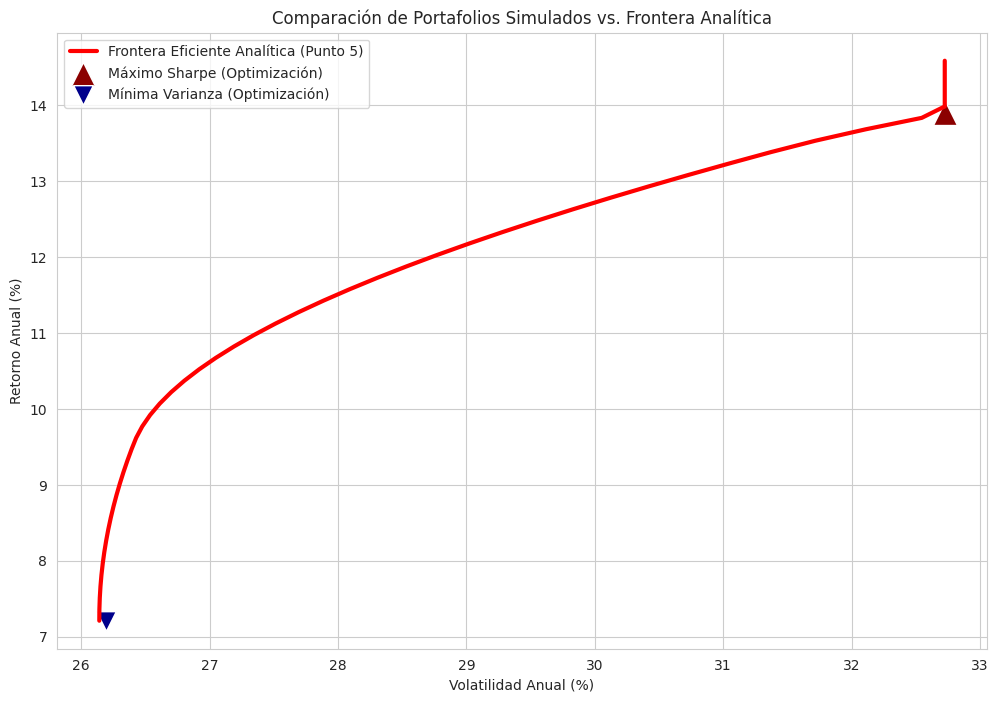

In [132]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

# Graficar la nube de puntos simulados (del Punto 4)
# Asegúrate de cargar tu df_deterministic aquí si no lo tienes
# plt.scatter(df_deterministic['Volatilidad_Anual_%'], df_deterministic['Retorno_Anual_%'], ...)

# Graficar la Curva Analítica de la Frontera Eficiente (Punto 5)
plt.plot(
    df_frontier['Volatilidad Anual (%)'],
    df_frontier['Retorno Anual (%)'],
    color='red',
    linestyle='-',
    linewidth=3,
    label='Frontera Eficiente Analítica (Punto 5)'
)

# Resaltar Portafolios Óptimos CALCULADOS POR OPTIMIZACIÓN
plt.scatter(
    vol_pmr * 100, er_pmr * 100, # Multiplicar por 100 para %
    color='darkred',
    marker='^', s=300, edgecolors='white',
    label='Máximo Sharpe (Optimización)'
)

plt.scatter(
    vol_min_var * 100, er_min_var * 100, # Multiplicar por 100 para %
    color='darkblue',
    marker='v', s=200, edgecolors='white',
    label='Mínima Varianza (Optimización)'
)

# #tiquetas y Títulos
plt.title('Comparación de Portafolios Simulados vs. Frontera Analítica')
plt.xlabel('Volatilidad Anual (%)')
plt.ylabel('Retorno Anual (%)')
plt.legend()
plt.grid(True)
plt.show()


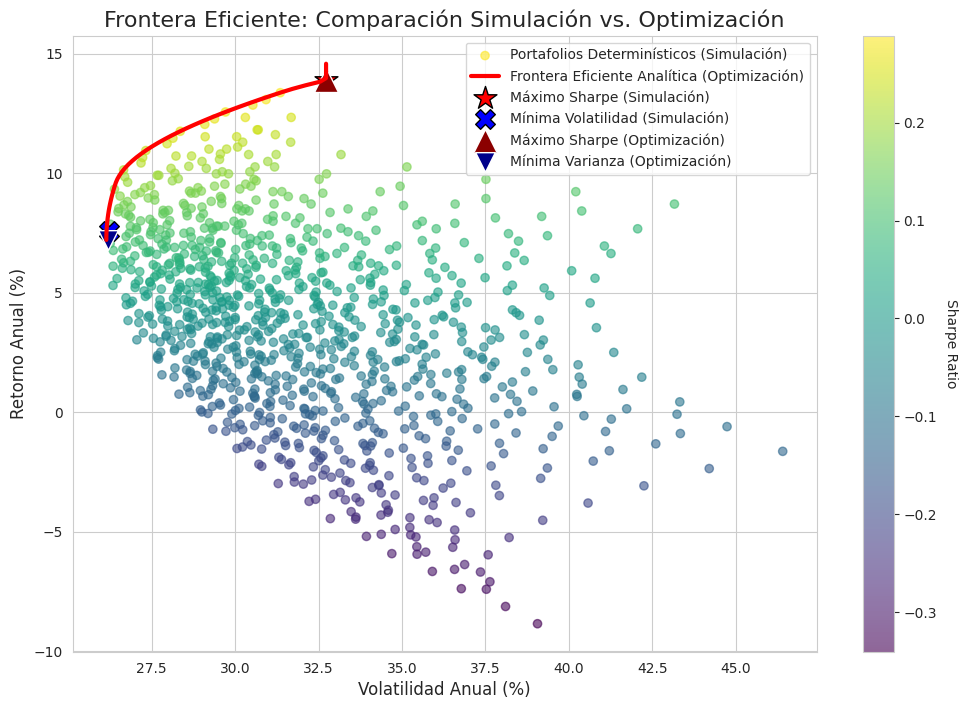

In [133]:
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

# --- A. Graficar todos los portafolios simulados (Punto 4) ---
scatter = plt.scatter(
    df_deterministic['Volatilidad_Anual_%'],
    df_deterministic['Retorno_Anual_%'],
    c=df_deterministic['Sharpe_Ratio'],
    cmap='viridis',
    marker='o',
    alpha=0.6,
    label='Portafolios Determinísticos (Simulación)'
)

# Añadir barra de color para el Sharpe Ratio
cbar = plt.colorbar(scatter)
cbar.set_label('Sharpe Ratio', rotation=270, labelpad=15)

# --- B. Graficar la Frontera Eficiente Analítica (Punto 5) ---
plt.plot(
    df_frontier['Volatilidad Anual (%)'],
    df_frontier['Retorno Anual (%)'],
    color='red',
    linestyle='-',
    linewidth=3,
    label='Frontera Eficiente Analítica (Optimización)' # Es la curva exacta
)

# --- C. Identificar y resaltar los portafolios clave ---

# a) Portafolio de Máximo Sharpe (de la simulación)
max_sharpe_portfolio = df_deterministic.iloc[0]

plt.scatter(
    max_sharpe_portfolio['Volatilidad_Anual_%'],
    max_sharpe_portfolio['Retorno_Anual_%'],
    color='red',
    marker='*',
    s=300,
    edgecolors='black', # Para resaltarlo mejor
    label='Máximo Sharpe (Simulación)'
)

# b) Portafolio de Mínima Volatilidad (de la simulación)
min_volatility_portfolio = df_deterministic.loc[
    df_deterministic['Volatilidad_Anual_%'].idxmin()
]

plt.scatter(
    min_volatility_portfolio['Volatilidad_Anual_%'],
    min_volatility_portfolio['Retorno_Anual_%'],
    color='blue',
    marker='X',
    s=200,
    edgecolors='black',
    label='Mínima Volatilidad (Simulación)'
)

# c) y d) Resaltar Portafolios Óptimos CALCULADOS POR OPTIMIZACIÓN
plt.scatter(
    vol_pmr * 100, er_pmr * 100, # Multiplicar por 100 para %
    color='darkred',
    marker='^', s=300, edgecolors='white',
    label='Máximo Sharpe (Optimización)'
)

plt.scatter(
    vol_min_var * 100, er_min_var * 100, # Multiplicar por 100 para %
    color='darkblue',
    marker='v', s=200, edgecolors='white',
    label='Mínima Varianza (Optimización)'
)

# --- D. Etiquetas y Títulos ---
plt.title('Frontera Eficiente: Comparación Simulación vs. Optimización', fontsize=16)
plt.xlabel('Volatilidad Anual (%)', fontsize=12)
plt.ylabel('Retorno Anual (%)', fontsize=12)
plt.legend(loc='best')
plt.grid(True)
plt.show()